## **Setup & Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble         import RandomForestRegressor
from xgboost                  import XGBRegressor
from sklearn.metrics         import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing   import StandardScaler
from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from catboost         import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor





## **Data Loading & Inspection**

In [3]:
car = pd.read_csv('car_price_prediction.csv')

In [4]:
print(car.shape)

(19237, 18)


In [5]:
car.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


## **Data Cleaning**

In [12]:
# 1) Read data
car = pd.read_csv('car_price_prediction.csv')

# 2) Print concise summary of each column’s dtype and missing‐value count
dtype_df = pd.DataFrame({
    'Column': car.columns,
    'Dtype':  car.dtypes.astype(str)
})
missing_df = car.isna().sum().reset_index()
missing_df.columns = ['Column', 'MissingCount']
summary_df = pd.merge(dtype_df, missing_df, on='Column')
print("\nColumn            Dtype        MissingCount")
print(summary_df.to_string(index=False))

# 3) Levy → numeric (replace “–” with NaN, convert to float, fill with median)
car['Levy'] = car['Levy'].replace('-', np.nan).astype(float)
median_levy = car['Levy'].median()
car['Levy'] = car['Levy'].fillna(median_levy)

# 4) Engine volume → extract numeric portion and convert to float
car['Engine volume'] = (
    car['Engine volume']
      .astype(str)
      .str.extract(r'(\d+\.?\d*)')[0]
      .astype(float)
)

# 5) Mileage → remove non‐digits (“ km”, commas) and convert to int
car['Mileage'] = (
    car['Mileage']
      .astype(str)
      .str.replace(r'[^\d]', '', regex=True)
      .astype(int)
)

# 6) Leather interior → map “Yes”/“No” to 1/0
car['Leather interior'] = car['Leather interior'].map({'Yes': 1, 'No': 0})

# 7) Doors → drop (too messy date‐like values), only if present
if 'Doors' in car.columns:
    car.drop(columns=['Doors'], inplace=True)

# 8) Wheel → standardize to “LHD”/“RHD”
car['Wheel'] = car['Wheel'].map({'Left wheel': 'LHD', 'Right-hand drive': 'RHD'})

# 9) Create Age = (2025 – Prod. year), then drop original “Prod. year”
car['Age'] = 2025 - car['Prod. year']
car.drop(columns=['Prod. year'], inplace=True)

# 10) Drop raw “ID” column (no predictive value)
car.drop(columns=['ID'], inplace=True)

# 11) Print final data types after cleaning
print("\nCleaned data types:\n", car.dtypes)



Column            Dtype        MissingCount
          Column   Dtype  MissingCount
              ID   int64             0
           Price   int64             0
            Levy  object             0
    Manufacturer  object             0
           Model  object             0
      Prod. year   int64             0
        Category  object             0
Leather interior  object             0
       Fuel type  object             0
   Engine volume  object             0
         Mileage  object             0
       Cylinders float64             0
   Gear box type  object             0
    Drive wheels  object             0
           Doors  object             0
           Wheel  object             0
           Color  object             0
         Airbags   int64             0

Cleaned data types:
 Price                 int64
Levy                float64
Manufacturer         object
Model                object
Category             object
Leather interior      int64
Fuel type            obj

## **EDA**

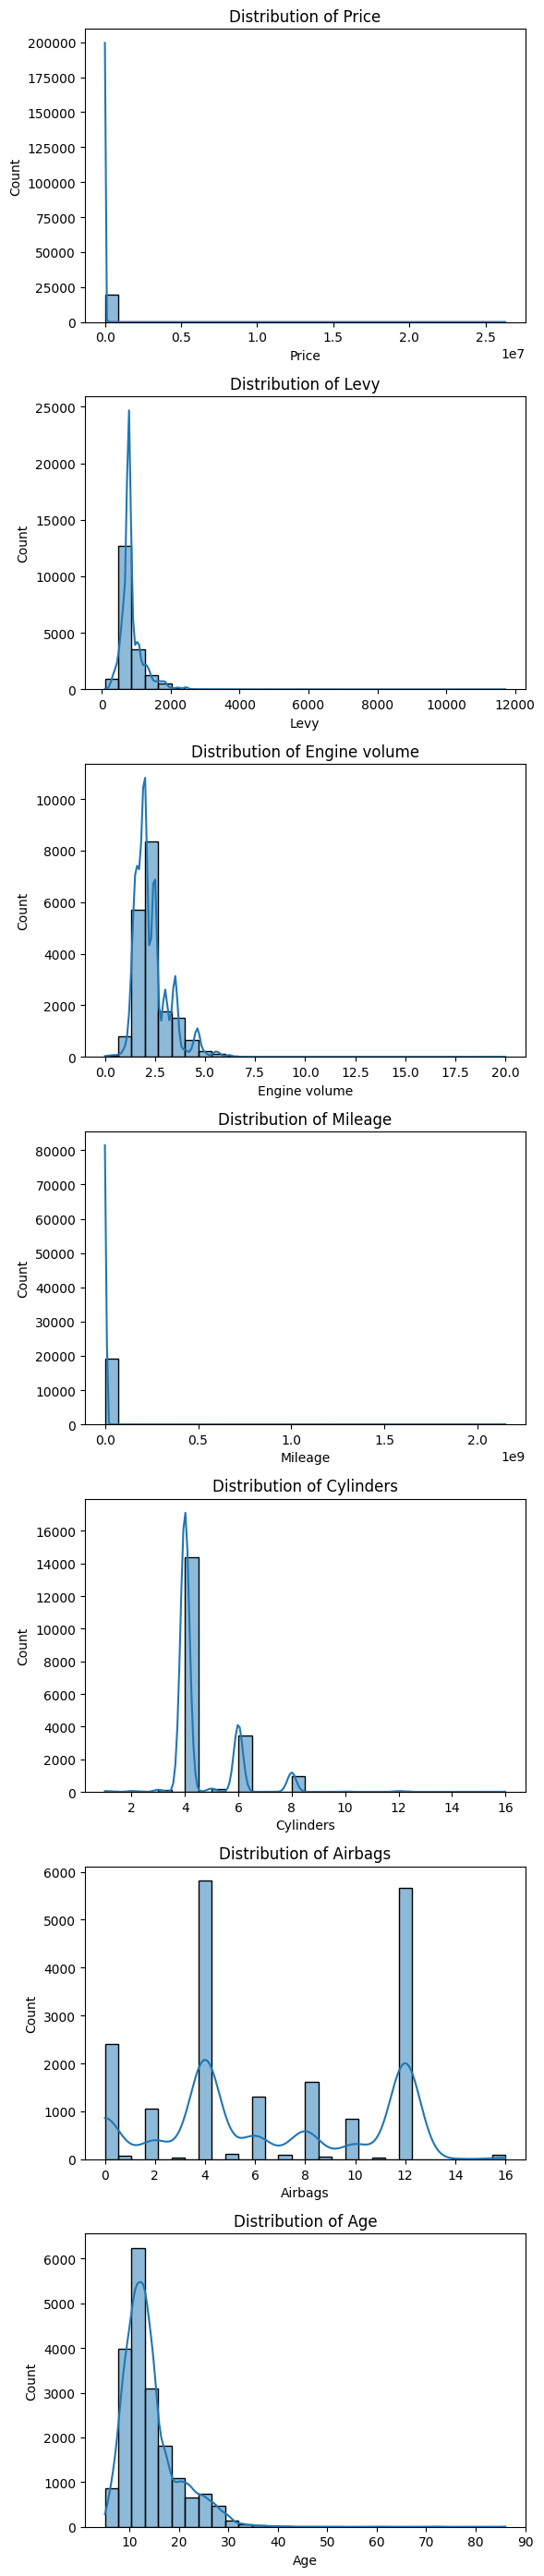

In [13]:
#Numeric distributions


num_feats = ['Price','Levy','Engine volume','Mileage','Cylinders','Airbags','Age']
fig, axes = plt.subplots(len(num_feats), 1, figsize=(6, 4*len(num_feats)))

for ax, col in zip(axes, num_feats):
    sns.histplot(car[col], bins=30, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()



In [14]:
# Cap extremes at the 99th percentile
for col in ['Price','Levy','Engine volume','Mileage','Age']:
    cap = car[col].quantile(0.99)
    print(f"Capping {col} at {cap:.0f}")
    car[col] = car[col].clip(upper=cap)


Capping Price at 84675
Capping Levy at 2225
Capping Engine volume at 5
Capping Mileage at 571247
Capping Age at 30


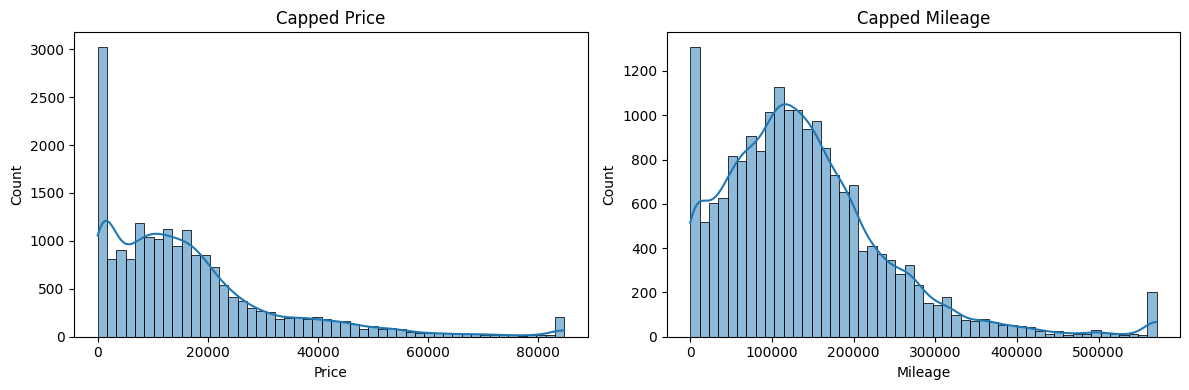

In [15]:
# Re-plot capped Price & Mileage

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(car['Price'],   bins=50, kde=True, ax=ax1).set_title("Capped Price")
sns.histplot(car['Mileage'], bins=50, kde=True, ax=ax2).set_title("Capped Mileage")
plt.tight_layout()
plt.show()


In [16]:
#  Drop brand-new (0 km) or extremely low-price cars
# Drop any listings with zero mileage
car = car[car['Mileage'] > 0]

# Also drop freebies or mistaken zero-price entries
car = car[car['Price'] > 1000]

print("After dropping, new shape:", car.shape)


After dropping, new shape: (16104, 16)


In [17]:
#  Re-cap at 99th percentile after dropping rows
for col in ['Price','Levy','Engine volume','Mileage','Age']:
    cap = car[col].quantile(0.99)
    car[col] = car[col].clip(upper=cap)


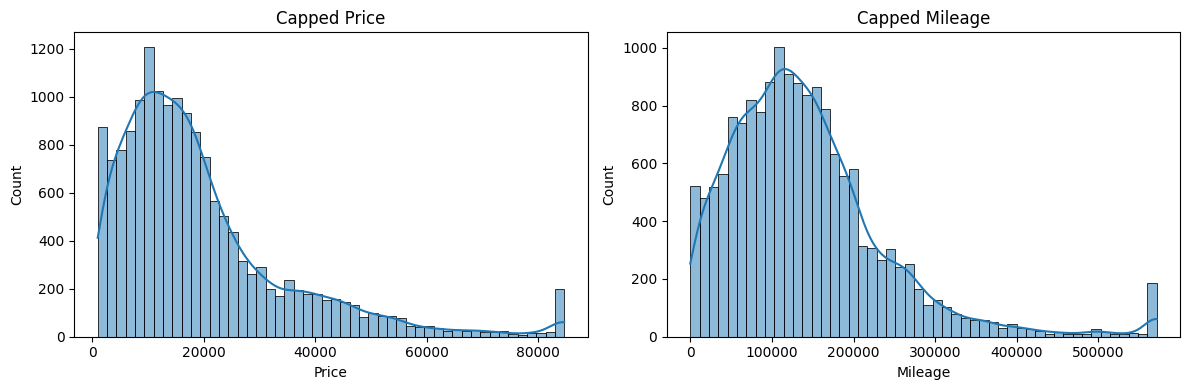

In [18]:
# Re-plot capped Price & Mileage


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(car['Price'],   bins=50, kde=True, ax=ax1).set_title("Capped Price")
sns.histplot(car['Mileage'], bins=50, kde=True, ax=ax2).set_title("Capped Mileage")
plt.tight_layout()
plt.show()


In [19]:
# Log-transform capped Price & Mileage
import numpy as np

for col in ['Price','Mileage']:
    car[col + '_log'] = np.log1p(car[col])
    print(f"{col:8} skew before: {car[col].skew():.2f}, after log: {car[col + '_log'].skew():.2f}")


Price    skew before: 1.75, after log: -0.57
Mileage  skew before: 1.59, after log: -2.02


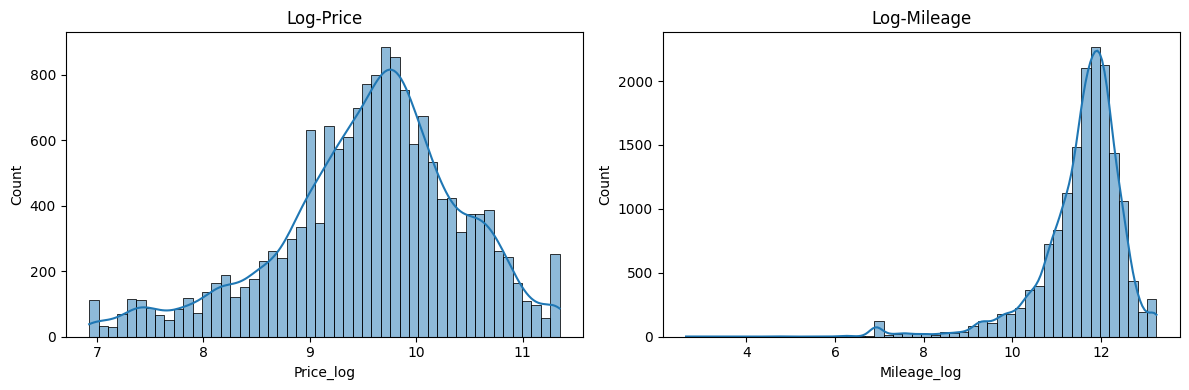

In [20]:
#  Verify log-transformed distributions


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.histplot(car['Price_log'],   bins=50, kde=True, ax=ax1).set_title("Log-Price")
sns.histplot(car['Mileage_log'], bins=50, kde=True, ax=ax2).set_title("Log-Mileage")
plt.tight_layout()
plt.show()


In [21]:
# Group rare levels into “Other”
for col in ['Category','Fuel type','Gear box type','Drive wheels']:
    vc = car[col].value_counts()
    rares = vc[vc < 300].index
    car[col] = car[col].replace(rares, 'Other')


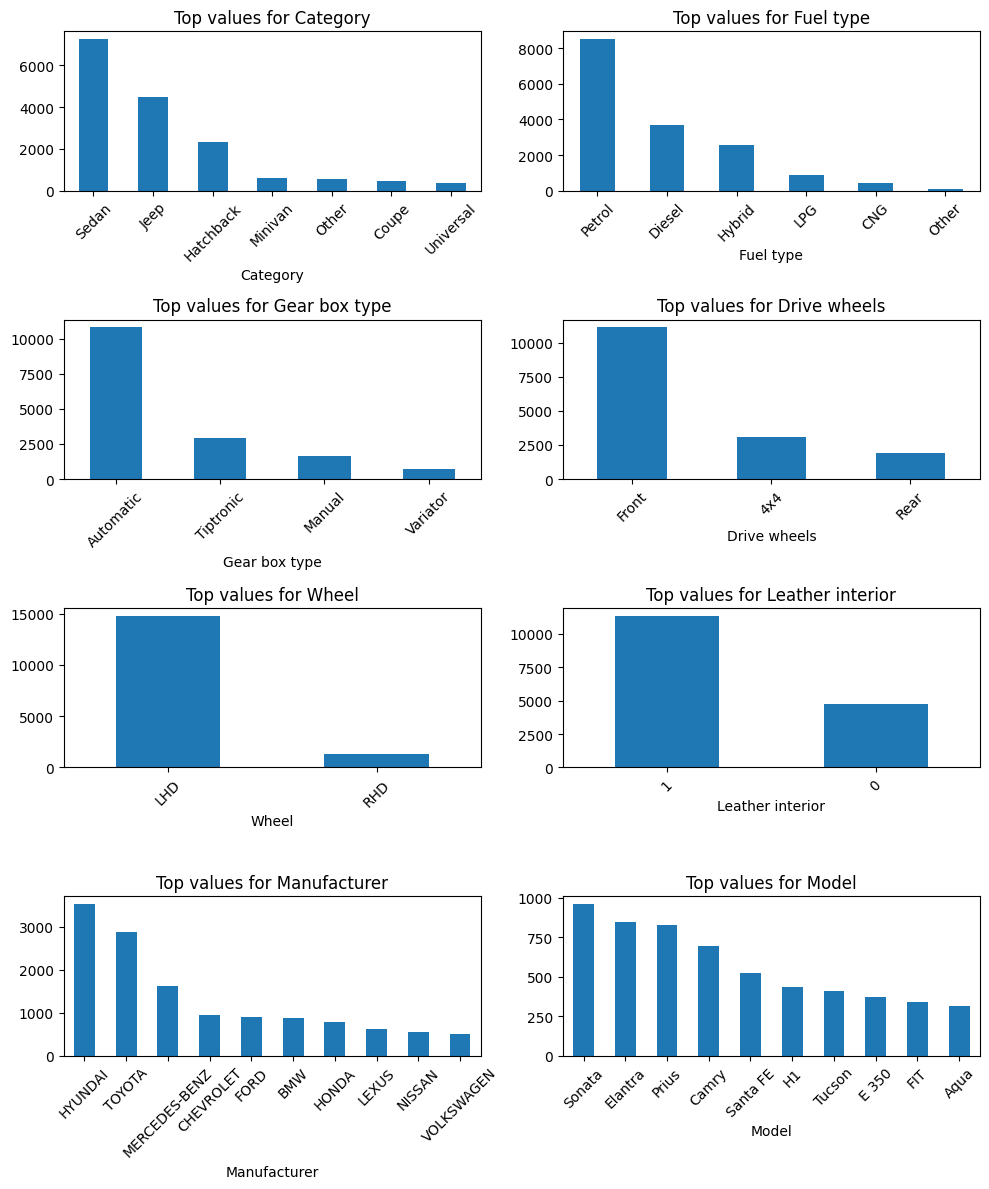

In [22]:
# Categorical counts
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
cat_feats = ['Category','Fuel type','Gear box type','Drive wheels','Wheel','Leather interior','Manufacturer','Model']

for ax, col in zip(axes.flatten(), cat_feats):
    car[col].value_counts().nlargest(10).plot.bar(ax=ax)
    ax.set_title(f"Top values for {col}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [23]:
# Frequency‐encode high‐cardinality text features
for col in ['Manufacturer','Model','Color']:
    freq = car[col].value_counts()
    car[col + '_freq'] = car[col].map(freq)

#Drop the raw text columns now that we have counts
car.drop(columns=['Manufacturer','Model','Color'], inplace=True)

print("After freq‐encoding, columns are:", car.columns.tolist())


After freq‐encoding, columns are: ['Price', 'Levy', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type', 'Drive wheels', 'Wheel', 'Airbags', 'Age', 'Price_log', 'Mileage_log', 'Manufacturer_freq', 'Model_freq', 'Color_freq']


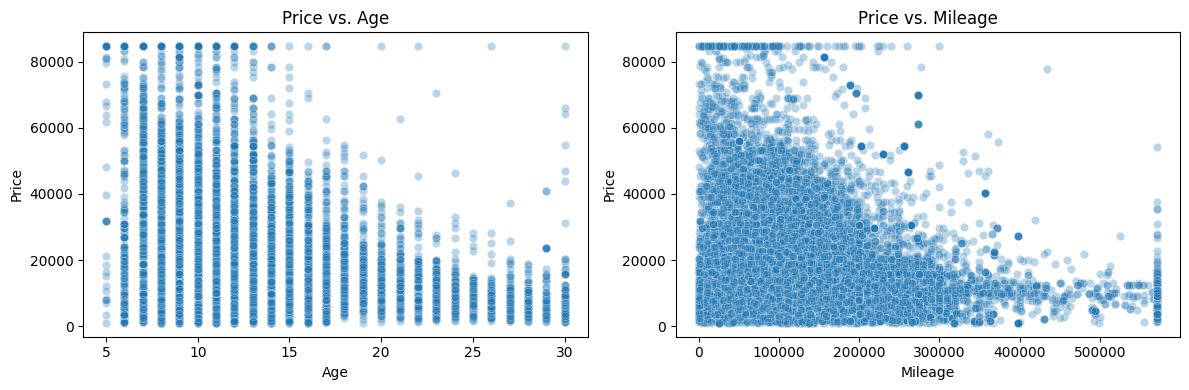

In [24]:
#Price vs. Age & Price vs. Mileage


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x='Age', y='Price', data=car, alpha=0.3, ax=ax1)
ax1.set_title("Price vs. Age")
sns.scatterplot(x='Mileage', y='Price', data=car, alpha=0.3, ax=ax2)
ax2.set_title("Price vs. Mileage")
plt.tight_layout()
plt.show()


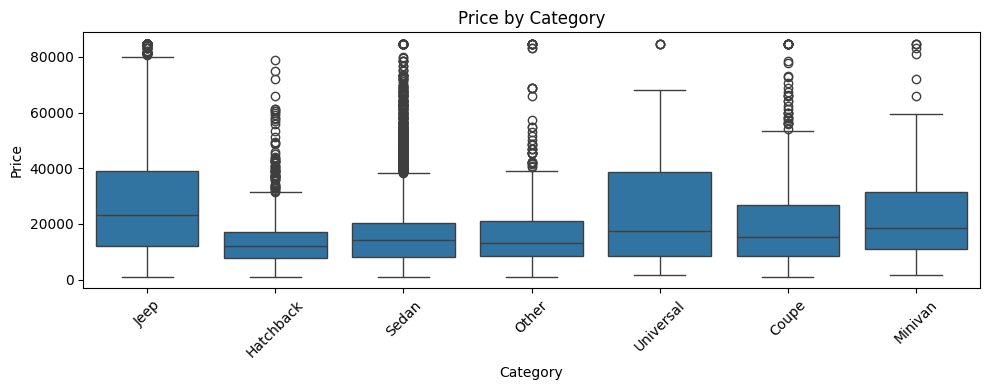

In [25]:
# Price distribution across Categories

plt.figure(figsize=(10,4))
sns.boxplot(x='Category', y='Price', data=car)
plt.xticks(rotation=45)
plt.title("Price by Category")
plt.xlabel("Category")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


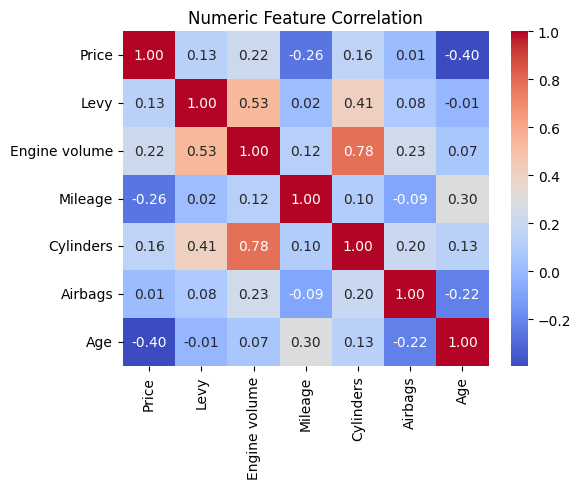

In [26]:
# Correlation Matrix (numeric features)
import matplotlib.pyplot as plt
import seaborn as sns

num_feats = ['Price','Levy','Engine volume','Mileage','Cylinders','Airbags','Age']
corr = car[num_feats].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Numeric Feature Correlation")
plt.tight_layout()
plt.show()


## **Feature Engineering**

In [27]:

# 1) Mileage per year
car['Mileage_per_year'] = car['Mileage'] / car['Age'].replace(0, 1)

# 2) Polynomial term for Age
car['Age_sq'] = car['Age'] ** 2

# 3) Interaction: engine size × age
car['EngineAge_int'] = car['Engine volume'] * car['Age']

# 4) Category mean price
cat_means = car.groupby('Category')['Price'].transform('mean')
car['Category_avg_price'] = cat_means

# 5) Quick check: list the new features and confirm the dataframe size
print("New features added:", ['Mileage_per_year','Age_sq','EngineAge_int','Category_avg_price'])
print("Shape now:", car.shape)


New features added: ['Mileage_per_year', 'Age_sq', 'EngineAge_int', 'Category_avg_price']
Shape now: (16104, 22)


## **Preprocessing & Train/Test Split**

In [29]:
# Select our input features—drop the 'Price' target and any helper log columns
X = car.drop(columns=['Price','Price_log'])
y = car['Price']


# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print("Training set:", X_train.shape, "Validation set:", X_test.shape)


#  Identify numeric vs. categorical features
num_cols = [
    'Levy','Engine volume','Mileage','Mileage_per_year',
    'Cylinders','Airbags','Age','Age_sq','EngineAge_int',
    'Category_avg_price',
    'Manufacturer_freq','Model_freq','Color_freq'
]
cat_cols = [
    'Category','Fuel type','Gear box type','Drive wheels','Wheel','Leather interior'
]



# Build transformers
num_pipeline = Pipeline([
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])


Training set: (12883, 20) Validation set: (3221, 20)


## **Installing catboost**

In [1]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.1 MB/s eta 0:00:00


## **Model Training & Evaluation**

In [30]:
# Defining three models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost'     : XGBRegressor(objective='reg:squarederror', random_state=42),
    'CatBoost'    : CatBoostRegressor(verbose=False, random_state=42)
}

# Fiting each and report metrics on the validation set
results = []
for name, mdl in models.items():
    pipe = Pipeline([('prep', preprocessor), ('model', mdl)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mse  = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, preds)
    r2   = r2_score(y_test, preds)
    results.append((name, mse, rmse, mae, r2))
    print(f"{name:12} → MSE: {mse:,.0f}, RMSE: {rmse:,.2f}, MAE: {mae:,.2f}, R²: {r2:.3f}")

# Ensemble of all three
ensemble = VotingRegressor(
    [(n, models[n]) for n in models],
    n_jobs=-1
)
ensemble_pipe = Pipeline([('prep', preprocessor), ('model', ensemble)])
ensemble_pipe.fit(X_train, y_train)
e_preds = ensemble_pipe.predict(X_test)
e_rmse = np.sqrt(mean_squared_error(y_test, e_preds))
e_r2   = r2_score(y_test, e_preds)
print(f"\nEnsemble    → RMSE: {e_rmse:,.2f}, R²: {e_r2:.3f}")


RandomForest → MSE: 53,961,380, RMSE: 7,345.84, MAE: 4,091.14, R²: 0.792
XGBoost      → MSE: 48,307,040, RMSE: 6,950.33, MAE: 4,280.40, R²: 0.814
CatBoost     → MSE: 46,559,319, RMSE: 6,823.44, MAE: 4,338.62, R²: 0.820

Ensemble    → RMSE: 6,673.50, R²: 0.828


## **Overfitting Check (Train vs Test)**

In [31]:
# Re-defining model
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost'     : XGBRegressor(objective='reg:squarederror', random_state=42),
    'CatBoost'    : CatBoostRegressor(verbose=False, random_state=42)
}

print("----- TRAINING SET METRICS -----")
for name, mdl in models.items():
    pipe = Pipeline([('prep', preprocessor), ('model', mdl)])
    pipe.fit(X_train, y_train)

    preds_train = pipe.predict(X_train)
    mse_t  = mean_squared_error(y_train, preds_train)
    rmse_t = np.sqrt(mse_t)
    mae_t  = mean_absolute_error(y_train, preds_train)
    r2_t   = r2_score(y_train, preds_train)
    print(f"{name:12} → RMSE: {rmse_t:,.2f}, MAE: {mae_t:,.2f}, R²: {r2_t:.3f}")

print("\n----- TEST SET METRICS (for reference) -----")
for name, mdl in models.items():
    pipe = Pipeline([('prep', preprocessor), ('model', mdl)])
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)

    mse_tt  = mean_squared_error(y_test, preds_test)
    rmse_tt = np.sqrt(mse_tt)
    mae_tt  = mean_absolute_error(y_test, preds_test)
    r2_tt   = r2_score(y_test, preds_test)
    print(f"{name:12} → RMSE: {rmse_tt:,.2f}, MAE: {mae_tt:,.2f}, R²: {r2_tt:.3f}")


----- TRAINING SET METRICS -----
RandomForest → RMSE: 3,155.92, MAE: 1,581.21, R²: 0.961
XGBoost      → RMSE: 4,284.45, MAE: 2,784.14, R²: 0.928
CatBoost     → RMSE: 5,413.34, MAE: 3,580.54, R²: 0.884

----- TEST SET METRICS (for reference) -----
RandomForest → RMSE: 7,345.84, MAE: 4,091.14, R²: 0.792
XGBoost      → RMSE: 6,950.33, MAE: 4,280.40, R²: 0.814
CatBoost     → RMSE: 6,823.44, MAE: 4,338.62, R²: 0.820


## **Training and Evaluating Tuned RF, XGB, and CatB Models on Preprocessed Data**

In [36]:
rf_tuned = RandomForestRegressor(
    n_estimators=300, max_depth=20, min_samples_split=10,
    min_samples_leaf=4, max_features=0.7, bootstrap=True,
    random_state=42, n_jobs=-1
)
xgb_tuned = XGBRegressor(
    objective='reg:squarederror', n_estimators=500,
    learning_rate=0.05, max_depth=6, subsample=0.8,
    colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0,
    random_state=42, verbosity=0
)
cat_tuned = CatBoostRegressor(
    iterations=1000, learning_rate=0.05, depth=6,
    l2_leaf_reg=3, random_seed=42,
    early_stopping_rounds=50, verbose=False
)

# Defining the pipelines so they exist in memory
# This block now comes *after* the model definitions
rf_pipe  = Pipeline([('prep', preprocessor), ('model', rf_tuned)])
xgb_pipe = Pipeline([('prep', preprocessor), ('model', xgb_tuned)])
cat_pipe = Pipeline([('prep', preprocessor), ('model', cat_tuned)])

# Re-fitting my preprocessor on the full train set
preprocessor.fit(X_train)

# Transform both train & test
X_train_p = preprocessor.transform(X_train)
X_test_p  = preprocessor.transform(X_test)

# Train RF & XGB directly on the transformed arrays
rf_tuned.fit(X_train_p, y_train)
xgb_tuned.fit(X_train_p, y_train)

# Train CatBoost on the same preprocessed arrays (with valid eval_set)
cat_tuned.fit(
    X_train_p, y_train,
    eval_set=(X_test_p, y_test)
)

# Evaluate all three on TRAIN & TEST
print("Model | RMSE_train | RMSE_test | R²_train | R²_test")
for name, mdl in [('RF', rf_tuned), ('XGB', xgb_tuned), ('Cat', cat_tuned)]:
    tr_pred = mdl.predict(X_train_p)
    te_pred = mdl.predict(X_test_p)
    rmse_tr = np.sqrt(mean_squared_error(y_train, tr_pred))
    rmse_te = np.sqrt(mean_squared_error(y_test,  te_pred))
    r2_tr   = r2_score(y_train, tr_pred)
    r2_te   = r2_score(y_test,  te_pred)
    print(f"{name:4}   | {rmse_tr:10.2f} | {rmse_te:9.2f} | {r2_tr:8.3f} | {r2_te:7.3f}")

Model | RMSE_train | RMSE_test | R²_train | R²_test
RF     |    5506.67 |   7523.21 |    0.880 |   0.782
XGB    |    4427.83 |   6779.46 |    0.923 |   0.823
Cat    |    5726.87 |   6934.38 |    0.871 |   0.814


## **5-Fold CV**

In [37]:

from sklearn.model_selection import cross_validate, KFold

# Using pipeline objects (which include preprocessing + model)
pipes = {
    'RF' : rf_pipe,
    'XGB': xgb_pipe,
    'Cat': cat_pipe
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2'  : 'r2'
}

for name, pipe in pipes.items():
    print(f" {name} 5-Fold CV Results ")
    scores = cross_validate(
        pipe,       # <-- pipeline, not raw estimator
        X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    train_rmse = -scores['train_rmse']
    test_rmse  = -scores['test_rmse']
    train_r2   = scores['train_r2']
    test_r2    = scores['test_r2']

    print(f"Train RMSE: {train_rmse.mean():.2f} ± {train_rmse.std():.2f}")
    print(f" Test RMSE: {test_rmse.mean():.2f} ± {test_rmse.std():.2f}")
    print(f"Train R²  : {train_r2.mean():.3f} ± {train_r2.std():.3f}")
    print(f" Test R²  : {test_r2.mean():.3f} ± {test_r2.std():.3f}\n")


 RF 5-Fold CV Results 
Train RMSE: 5485.31 ± 45.06
 Test RMSE: 7527.51 ± 242.08
Train R²  : 0.882 ± 0.001
 Test R²  : 0.777 ± 0.008

 XGB 5-Fold CV Results 
Train RMSE: 4366.37 ± 81.88
 Test RMSE: 6896.19 ± 273.78
Train R²  : 0.925 ± 0.002
 Test R²  : 0.813 ± 0.012

 Cat 5-Fold CV Results 
Train RMSE: 5662.20 ± 64.57
 Test RMSE: 7193.02 ± 256.08
Train R²  : 0.874 ± 0.003
 Test R²  : 0.796 ± 0.012



## **XGBoost**

In [38]:
# Retrain on full training data
xgb_pipe.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['Levy', 'Engine volume',
                                                   'Mileage',
                                                   'Mileage_per_year',
                                                   'Cylinders', 'Airbags',
                                                   'Age', 'Age_sq',
                                                   'EngineAge_int',
                                                   'Category_avg_price',
                                                   'Manufacturer_freq',
                                                   'Model_freq',
                                                   'Color_freq']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [39]:

preds = xgb_pipe.predict(X_test)
mse   = mean_squared_error(y_test, preds)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_test, preds)
r2    = r2_score(y_test, preds)

print(f"Final Test MSE : {mse:,.2f}")
print(f"Final Test RMSE: {rmse:,.2f}")
print(f"Final Test MAE : {mae:,.2f}")
print(f"Final Test R²  : {r2:.3f}")


Final Test MSE : 45,961,040.00
Final Test RMSE: 6,779.46
Final Test MAE : 4,143.09
Final Test R²  : 0.823


##**Demo**

In [40]:


# Example new car spec
new_car = pd.DataFrame([{
    'Levy'             : 259.0,
    'Engine volume'    : 1.4,
    'Mileage'          : 65000,
    'Cylinders'        : 4.0,
    'Airbags'          : 10,
    'Age'              : 11,
    'Mileage_per_year' : 65000/11,
    'Age_sq'           : 11**2,
    'EngineAge_int'    : 1.4*11,
    'Category_avg_price': car['Category_avg_price'].median(),
    'Manufacturer_freq': car['Manufacturer_freq'].median(),
    'Model_freq'       : car['Model_freq'].median(),
    'Color_freq'       : car['Color_freq'].median(),
    'Category'         : 'Hatchback',
    'Fuel type'        : 'Petrol',
    'Gear box type'    : 'Automatic',
    'Drive wheels'     : 'Front',
    'Wheel'            : 'LHD',
    'Leather interior' : 0
}])

pred_price = xgb_pipe.predict(new_car)[0]
print(f"Predicted price: ${pred_price:,.2f}")


Predicted price: $15,584.38


## **Comparing Actual vs. Predicted Prices**

In [41]:


# Taking first 10 from your test split
X_demo = X_test.reset_index(drop=True).loc[:9]
y_demo = y_test.reset_index(drop=True).loc[:9]

# Predict
preds = xgb_pipe.predict(X_demo)

# Build a comparison table
df_demo = pd.DataFrame({
    'ActualPrice'   : y_demo,
    'PredictedPrice': preds
})
df_demo['Error']     = df_demo['PredictedPrice'] - df_demo['ActualPrice']
df_demo['AbsError']  = df_demo['Error'].abs()

print(df_demo)


   ActualPrice  PredictedPrice        Error     AbsError
0         7840     7885.833008    45.833008    45.833008
1        28830    23142.960938 -5687.039062  5687.039062
2        16308    15754.707031  -553.292969   553.292969
3        16621    13720.913086 -2900.086914  2900.086914
4        10976    10601.761719  -374.238281   374.238281
5        18503    15164.257812 -3338.742188  3338.742188
6         8624     7806.659668  -817.340332   817.340332
7        11290    12695.265625  1405.265625  1405.265625
8        14113    13437.136719  -675.863281   675.863281
9        16308    14591.070312 -1716.929688  1716.929688


## **Residual Analysis on the FULL Test Set**

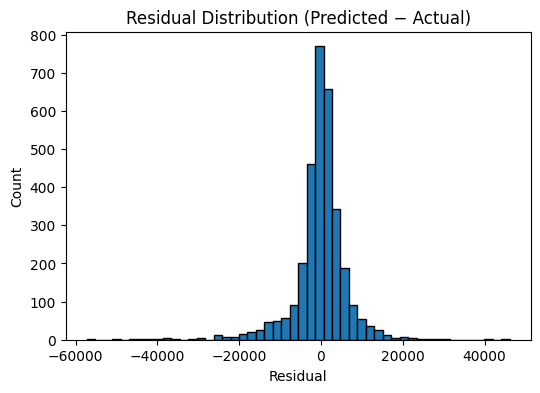

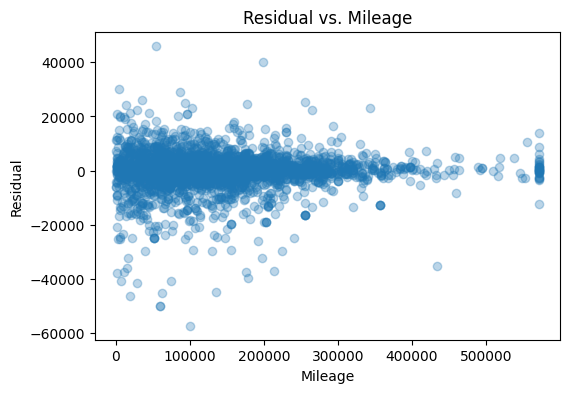

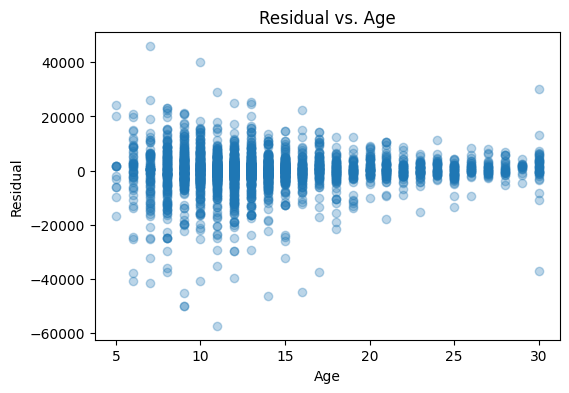

In [42]:
# Get predictions on the entire test set
preds_test = xgb_pipe.predict(X_test)

# Compute residuals: prediction minus actual
residuals = preds_test - y_test.to_numpy()

# Histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, edgecolor='k')
plt.title("Residual Distribution (Predicted − Actual)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# Scatter: residual vs. Mileage
plt.figure(figsize=(6,4))
plt.scatter(X_test['Mileage'], residuals, alpha=0.3)
plt.title("Residual vs. Mileage")
plt.xlabel("Mileage")
plt.ylabel("Residual")
plt.show()

# Scatter: residual vs. Age
plt.figure(figsize=(6,4))
plt.scatter(X_test['Age'], residuals, alpha=0.3)
plt.title("Residual vs. Age")
plt.xlabel("Age")
plt.ylabel("Residual")
plt.show()
